In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Thu Mar  19 20:45:08 2023

@author: Subramanian
"""
import numpy as np
import planetary_data as pd
import tools as t
import re
from orbpro import orbpro as OP
from astropy import units as u
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.plotting.static import StaticOrbitPlotter
from scipy.optimize import minimize_scalar
from poliastro.maneuver import Maneuver
from datetime import datetime, timedelta
from astropy.time import Time
from scipy.stats import norm

In [2]:
# Calculate the distance between two satellites' positions
def distance(sat1, sat2):
    return np.linalg.norm(sat1.r - sat2.r)

# Calculate the time of closest approach between two satellites within a specified time span
def time_of_closest_approach(sat1, sat2, t_span):
    res = minimize_scalar(lambda t: distance(sat1.propagate(t * u.s), sat2.propagate(t * u.s)), bounds=t_span, method='bounded')
    return res.fun, res.x

# Perform a collision avoidance maneuver by applying a delta-V to the satellite's velocity
def collision_avoidance_maneuver(sat1, delta_v):
    return sat1.apply_maneuver(Maneuver.impulse(delta_v))

# Calculate the time of probability of collision between two satellites within a specified time span
def probability_of_collision(min_distance, R1, R2, sigma_radial, sigma_tangential):
    min_distance /= 1000  # Convert distance to meters
    R = R1 + R2
    sigma_total = np.sqrt(sigma_radial**2 + sigma_tangential**2)
    Pc = norm.cdf(-min_distance / (np.sqrt(2) * sigma_total))
    return Pc

def calc_epoch(tle_file):
    with open(tle_file, 'r') as file:
        lines = file.readlines()

    # Extract the epoch from the second line of the TLE
    tle_line2 = lines[1].strip()
    epoch_str = re.findall(r"\d{5}\.\d+", tle_line2)[0]

    # Convert the epoch string to a datetime object
    epoch_year = int("20" + epoch_str[:2])
    epoch_day_fraction = float(epoch_str[2:])
    epoch_date = datetime(epoch_year, 1, 1) + timedelta(days=epoch_day_fraction - 1)

    # Convert the datetime object to an Astropy Time object
    epoch_astropy = Time(epoch_date)

    return epoch_astropy

Closest approach time (s): 366669.93
Closest approach distance (km): 1576.75 km
Probability of collision: 0.480117

 Performing collision avoidance maneuver... 

Closest approach time (s): 366576.31, Closest approach distance (km): 0.82 km and Probability of collision: 0.489717 after 1 manuvers
Closest approach time (s): 366603.59, Closest approach distance (km): 1.33 km and Probability of collision: 0.483287 after 2 manuvers
Closest approach time (s): 378282.82, Closest approach distance (km): 3.06 km and Probability of collision: 0.461477 after 3 manuvers
Closest approach time (s): 224878.80, Closest approach distance (km): 0.61 km and Probability of collision: 0.492242 after 4 manuvers
Closest approach time (s): 230854.14, Closest approach distance (km): 0.78 km and Probability of collision: 0.490145 after 5 manuvers
Closest approach time (s): 231299.72, Closest approach distance (km): 3.27 km and Probability of collision: 0.458865 after 6 manuvers


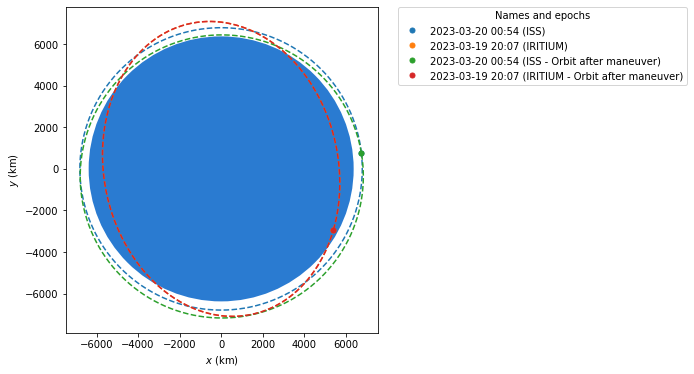

In [3]:
tspan = 3600*24*7.0
dt = 10.0

# Obtain orbital elements from TLE files
orbital_elements_ISS = t.tle2coes('stations.txt')
orbital_elements_IRI = t.tle2coes('iritium.txt')

# Create Orbit objects for the International Space Station (ISS) and an Iridium satellite (IRI)
ISS = Orbit.from_classical(Earth, *orbital_elements_ISS, epoch = calc_epoch("stations.txt"))
IRI = Orbit.from_classical(Earth, *orbital_elements_IRI, epoch = calc_epoch("iritium.txt"))

# Propagate orbits and find the time of closest approach
# Define the time span for the conjunction assessment

t_span = (0, 24*60*60*7)

# Calculate the time of closest approach and minimum distance between the satellites
min_distance, t_closest_approach = time_of_closest_approach(ISS, IRI, t_span)

print(f"Closest approach time (s): {t_closest_approach:.2f}")
print(f"Closest approach distance (km): {min_distance:.2f}")

# Calculate probability of collision
R_ISS = 10.0  # Radius of the ISS in meters
R_IRI = 1.0   # Radius of the Iridium satellite in meters
sigma_radial = 20.0  # Radial error in meters
sigma_tangential = 10.0  # Tangential error in meters

Pc = probability_of_collision(min_distance, R_ISS, R_IRI, sigma_radial, sigma_tangential)
print(f"Probability of collision: {Pc:.6f}")


# Plot the orbits of both satellites
plotter = StaticOrbitPlotter()
plotter.plot(ISS, label="ISS")
plotter.plot(IRI, label="IRITIUM")

# Define minimum separation distance for conjunction assessment (in km)
min_separation_distance = 1.0 * u.km

# Perform a collision avoidance maneuver if the probability of collision is higher than the acceptable limit
Pc_limit = 0.46  # Acceptable probability of collision limit
# Pc_limit = 1e-6  # Acceptable probability of collision limit

# If the closest approach distance is less than the minimum separation distance, perform a collision avoidance maneuver
if min_distance < min_separation_distance or Pc > Pc_limit:
    n = 0
    print("\n Performing collision avoidance maneuver... \n")
    while (min_distance < min_separation_distance or Pc > Pc_limit):
        delta_v = np.array([0.1, 0, 0]) * u.km / u.s  # Define delta-V vector for the maneuver
        ISS = collision_avoidance_maneuver(ISS, delta_v)
        n += 1

        # Recalculate the closest approach after the maneuver
        min_distance, t_closest_approach = time_of_closest_approach(ISS, IRI, t_span)

        # Recalculate probability of collision
        Pc = probability_of_collision(min_distance, R_ISS, R_IRI, sigma_radial, sigma_tangential)

        print(f"Closest approach time (s): {t_closest_approach:.2f}, Closest approach distance (km): {min_distance:.2f} and Probability of collision: {Pc:.6f} after {n} manuvers")

# Plot the orbits
plotter.plot(ISS, label="ISS - Orbit after maneuver")
plotter.plot(IRI, label="IRITIUM - Orbit after maneuver")